In [198]:
import pdfplumber # to extract data from PDFs
import re # regular expressions
import pandas as pd # dataframe manipulations
from io import StringIO # not really sure to be honest?
import time  # Import the time module to see how long the whole thing takes
import matplotlib.pyplot as plt

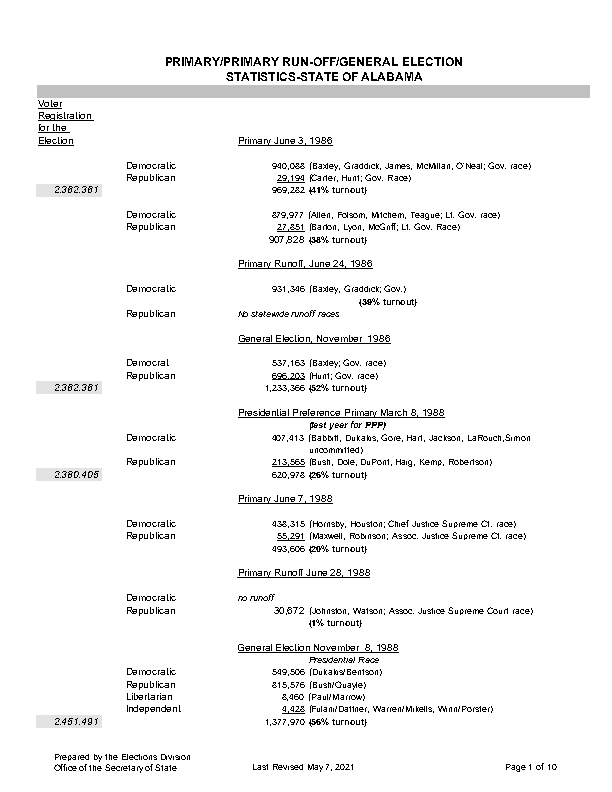

In [266]:
pdf = pdfplumber.open("Comprehensive Voter Turnout 1986-2020.pdf")
# peeking at first page
p0 = pdf.pages[0]
im = p0.to_image()
im

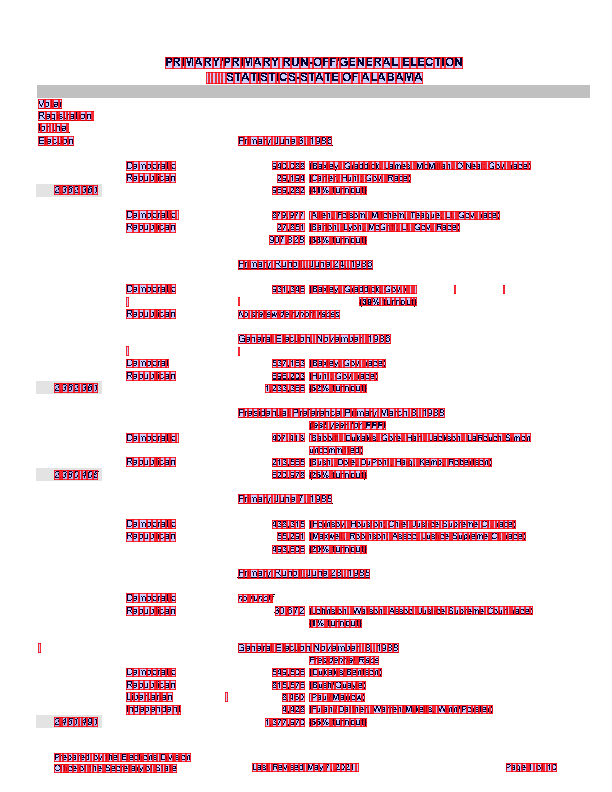

In [265]:
im.reset().draw_rects(p0.chars) # put a rectangle around characters

In [268]:
text = p0.extract_text(keep_blank_chars = True) # extract the text keeping the blank spaces
print(text)

PRIMARY/PRIMARY RUN-OFF/GENERAL ELECTION
      STATISTICS-STATE OF ALABAMA
Voter
Registration 
for the 
Election Primary June 3, 1986
Democratic 940,088 (Baxley, Graddick, James, McMillan, O'Neal; Gov. race)
Republican 29,194 (Carter, Hunt; Gov. Race)
2,362,361 969,282 (41% turnout)
Democratic  879,977 (Allen, Folsom, Mitchem, Teague; Lt. Gov. race)
Republican 27,851 (Barton, Lyon, McGriff; Lt. Gov. Race)
907,828 (38% turnout)
Primary Runoff, June 24, 1986
Democratic 931,346 (Baxley, Graddick; Gov.)        
    (39% turnout)
Republican No statewide runoff races
General Election, November  1986
   
Democrat 537,163 (Baxley; Gov. race)
Republican 696,203 (Hunt; Gov. race)
2,362,361 1,233,366 (52% turnout)
Presidential Preference Primary March 8, 1988
(last year for PPP)
Democratic  407,413 (Babbitt, Dukakis, Gore, Hart, Jackson, LaRouch,Simon
uncommitted)
Republican 213,565 (Bush, Dole, DuPont, Haig, Kemp, Robertson)
2,380,405 620,978 (26% turnout)
Primary June 7, 1988
Democratic 438,315

In [257]:
import pdfplumber
import re
import pandas as pd

# Start timing
start_time = time.time()

# Open and extract text from the PDF
with pdfplumber.open('Comprehensive Voter Turnout 1986-2020.pdf') as pdf:
    extracted_text = ""
    for page in pdf.pages:
        extracted_text += page.extract_text()

# Split the text into lines
lines = extracted_text.split('\n')

# Regular expression to match lines with a percent symbol or a date,
# but exclude lines containing "Office of the Secretary of State Last Revised"
pattern = r"^(?!.*Office of the Secretary of State Last Revised).*(%|, \d{4}).*$"

# List to hold the matched lines
matched_lines = []

# Apply the regex to each line and store matches in the list
for line in lines:
    if re.match(pattern, line):
        matched_lines.append(line.strip())

# Convert the list of matched lines into a pandas DataFrame
df = pd.DataFrame(matched_lines, columns=['Matched Line'])

# Calculate duration
end_time = time.time()
duration = end_time - start_time
num_pages = len(pdf.pages)
print(f"{num_pages} pages of PDF extracted in {duration:.2f} seconds.")


10 pages of PDF extracted in 0.35 seconds.


In [258]:
# Get the dimensions of the DataFrame
dimensions = df.shape

# Print the dimensions
print(f"Rows: {dimensions[0]}, Columns: {dimensions[1]}")


Rows: 124, Columns: 1


In [259]:
df

,Matched Line
0,"Election Primary June 3, 1986"
1,"2,362,361 969,282 (41% turnout)"
2,"907,828 (38% turnout)"
3,"Primary Runoff, June 24, 1986"
4,(39% turnout)
...,...
119,"724,222 62% of total ballots cast"
120,"Primary Runoff Election - July 14, 2020"
121,"3,605,733 Total Ballots Cast 628,236 (17% turn..."
122,"General Election - November 3, 2020"


In [262]:
# Step 1: Define regex for "month day, year"
# This regex looks for "Month day, year" patterns at the end of a string
date_pattern = r'([A-Za-z]+ \d{1,2}, \d{4})$'

# Function to extract the date and separate the line
def extract_date(row):
    match = re.search(date_pattern, row)
    if match:
        # Extract the date and return the remaining line and the date
        date = match.group(0)
        new_row = row[:row.rfind(date)].strip()  # Remove the date part from the line
        return pd.Series([new_row, date])
    return pd.Series([row, None])

percent_pattern = r'\(\s*([\d]{1,2}(\.\d+)?%)\s*[^()]*\)' # this is ** from above but modified to accept deicmals

# Function to extract turnout percent
def extract_percent(row):
    match = re.search(percent_pattern, row)
    if match:
        return match.group(1)  # Return the full match including the '%'
    return pd.NA  # Return NaN if no match

# Apply the function to extract dates
df[['Line', 'Date']] = df['Matched Line'].apply(extract_date)

# Fill down the 'Date' column using ffill
df['Date'] = df['Date'].ffill()

# Apply the function to create a new column 'Turnout Percent'
df['Turnout Percent'] = df['Matched Line'].apply(extract_percent)

# Remove '%' sign and convert to numeric, turning non-numeric to NaN
df['Turnout Percent'] = df['Turnout Percent'].str.replace('%', '', regex=False).replace('', pd.NA)
df['Turnout Percent'] = pd.to_numeric(df['Turnout Percent'], errors='coerce')

# Fill percents upwards
df['Turnout Percent'] = df['Turnout Percent'].bfill()

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')

In [263]:
df[70:100]

,Matched Line,Line,Date,Turnout Percent
70,"Primary June 6, 2006",Primary,2006-06-06,38.400
71,"2,413,279 926,556 (38.4% turnout)","2,413,279 926,556 (38.4% turnout)",2006-06-06,38.400
72,"Primary Runoff July 18, 2006",Primary Runoff,2006-07-18,50.600
73,"General Election November 7, 2006",General Election,2006-11-07,50.600
74,"2,469,807 1,250,401 (50.6% turnout)","2,469,807 1,250,401 (50.6% turnout)",2006-11-07,50.600
75,"2,557,021 1,088,835 (42.6% turnout)","2,557,021 1,088,835 (42.6% turnout)",2006-11-07,42.600
76,"Primary June 3, 2008",Primary,2008-06-03,73.800
77,"2,597,081 392,297 (15.1 % turnout)","2,597,081 392,297 (15.1 % turnout)",2008-06-03,73.800
78,"Primary Runoff July 15, 2008",Primary Runoff,2008-07-15,73.800
79,"2,604,803 103,670 (.04 % turnout)","2,604,803 103,670 (.04 % turnout)",2008-07-15,73.800


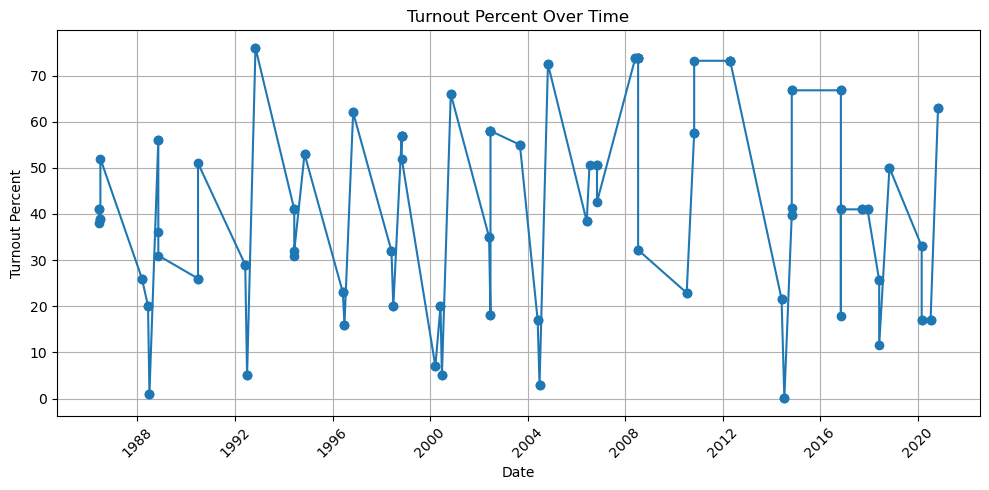

In [264]:
# Create the line graph
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Turnout Percent'], marker='o')
plt.title('Turnout Percent Over Time')
plt.xlabel('Date')
plt.ylabel('Turnout Percent')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()
